# Inpainting of satellite Images

The project is about image inpainting, that consists in filling deteriorated, or missing parts of a picture to reconstruct a complete image.

The dataset taken into consideration is the tensorflow EuroSAT dataset based on Sentinel-2 satellite images, in the the rgb version. This consists of 27000 images, at resolution 64x64.

A portion of the image is randomly masked according to the procedure described below. The goal is to reconstruct the full image.



## Introduction
The project has been very interesting and, above all, challenging, particularly from the perspective of researching and constructing the best model to effectively perform the assigned task. Initially I believed that a model only focused on image reconstruction wouldn't be sufficient. As a matter of facts, I attempted to implement not only a generator structured as a UNet but also a discriminator to provide feedback to the UNet, enabling continuous improvement to better fool the discriminator. Essentially, the first model I tried to build was a simplified version of a GAN. However, I didn't achieved the desired results, mainly because I couldn't halt the discriminator from continually improving itself beyond a certain threshold, making it effectively unreachable by the UNet. Therefore, after briefly testing this model, I transitioned to a model consisting only in a UNet network, experimenting with various configurations, which I will provide a more detailed explanation of later.

In the following notebook, I didn't include the code for the discriminator, but I did include the different UNet configurations.

## Necessary imports

In [8]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Conv2DTranspose, Activation, LeakyReLU, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import Loss
from skimage.metrics import structural_similarity as ssim
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [27]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

## Splitting dataset

I tried different dataset splitting configurations, focusing the majority of the data in the training set.

In most of the executions I conducted, I used a significantly smaller amount of data for the test set. This is because the generator produces masked images with random variables, so even if the test set contains fewer original images, it is possible to generate more masked images in different ways. Regarding the validation phase, I used either an 80%-20% or 90%-10% split, starting from the training set.

In [28]:
ds_train = ds_train['train']
ds_train = ds_train.shuffle(1000, seed = 42)

# Splitting dataset
train_dataset = ds_train.take(17000)
test_dataset = ds_train.skip(17000)
total_samples = len(train_dataset)
train_samples = int(0.80 * total_samples)
validation_samples = total_samples - train_samples

training_set = train_dataset.take(train_samples)
validation_set = train_dataset.skip(train_samples).take(validation_samples)

print("Training set size:",len(training_set))
print("Validation set size:",len(validation_set))
print("Test set size:",len(test_dataset))

Training set size: 13600
Validation set size: 3400
Test set size: 10000


# Generator

The generator gives you your training data.
We create a mask by drawing random vertical lines at different angles, and with variable variable width. The portion of the image retained is that under the mask.

In [59]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

batch_size = 8
# Batching dataset
train_dataset_batched = train_dataset.batch(batch_size)
validation_dataset_batched = validation_set.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
# Generator definition
train_generator = generator(train_dataset_batched)
val_generator = generator(validation_dataset_batched)
test_generator = generator(test_dataset_batched)
# Steps per epoch
training_steps_per_epoch = len(training_set) // batch_size
validation_steps_per_epoch = len(validation_set) // batch_size
# steps_per_epoch_test = len(test_dataset) // batch_size

print("training_steps_per_epoch:",training_steps_per_epoch)
print("validation_steps_per_epoch:",validation_steps_per_epoch)
# print("steps_per_epoch_test:",steps_per_epoch_test)

training_steps_per_epoch: 1700
validation_steps_per_epoch: 425


# UNet Generator

### More Complex Architecture Attempted
Explanation of the structure:
1. Contracting Path (Encoder):
  this part of the network is designed to capture and learn features of the image at different scales.
  Each convolutional block (conv_block) consists of two convolutional layers followed by batch normalization, activation (ReLU or LeakyReLU), and dropout (optional).
  4 contracting blocks (conv1, conv2, conv3, conv4) are used with a reduction in image size via max pooling after each block.

2. Bottleneck:
  this is the deepest point of the network, where the most abstract features of the image are captured. It consists of another convolutional block (conv5) without max pooling.

3. Expanding Path (Decoder): this part of the network is designed to restore the resolution of the segmented image. It uses deconvolution operations (transposed convolution) to increase the size of the image.
After each deconvolution operation, the results are concatenated with the corresponding feature maps from the Encoder.
Each deconvolution block (conv6, conv7, conv8, conv9) follows the same structure as the contracting blocks, but with a lower number of filters as the image dimensions are increasing.
The final output layer (conv9) uses a convolution with a kernel size of 3 and no activation.

4. Output Layer: the output of the network is a segmented image represented by three channels, with a sigmoid activation to produce values between 0 and 1 for each pixel, representing the probability of belonging to the class of interest.



In [133]:
def conv_block(inputs, filters, kernel_size=3, activation='relu', dropout_rate=0.25):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)
    return conv

def unet_generator(input_shape, dropout_rate=0.25):
    inputs = Input(shape=input_shape)

    # Contracting Path / encoder
    conv1 = conv_block(inputs, 64, dropout_rate=dropout_rate)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128, dropout_rate=dropout_rate)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256, dropout_rate=dropout_rate)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512, dropout_rate=dropout_rate)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024, dropout_rate=dropout_rate)

    # Expanding Path / decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(up6, 512, activation='leaky_relu', dropout_rate=dropout_rate)

    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(up7, 256, activation='leaky_relu', dropout_rate=dropout_rate)

    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(up8, 128, activation='leaky_relu', dropout_rate=dropout_rate)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, padding='same')(up9)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

### Architecture 2
In this UNet network there is no Batch Normalization and it is used only the ReLU activation function.
Furthermore, the bottleneck is smaller (less filters) than the previous architecture's one.

In [149]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same', activation=activation)(inputs)
    conv = Conv2D(filters, kernel_size, padding='same', activation=activation)(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 512)

    # Expanding Path / decoder
    up6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = conv_block(up6, 256)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = conv_block(up7, 128)

    up8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = conv_block(up8, 64)

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, padding='same', activation='relu')(up9)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

### Architecture 3


In [191]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 512)

    # Expanding Path / decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 256)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 128)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 64)

    conv8 = Conv2D(64, 3, padding='same')(conv7)
    conv8 = Activation('relu')(conv8)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Architecture 4

In [30]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    if activation == 'leaky_relu':
        conv = LeakyReLU(alpha=0.2)(conv)
    else:
        conv = Activation('relu')(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 512)

    # Expanding Path / decoder
    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 256)

    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 128)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 64)

    conv8 = Conv2D(64, 3, padding='same')(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Architecture 5

In [14]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 256)

    # Expanding Path / Decoder
    up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 128)

    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 64)

    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 32)

    conv8 = Conv2D(32, 3, padding='same')(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Architecture 6

In [16]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / encoder
    conv1 = conv_block(inputs, 16)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 128)

    # Expanding Path / decoder
    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 64)

    up6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 32)

    up7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 16)

    conv8 = Conv2D(16, 3, padding='same')(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Architecture 7

In [20]:
def conv_block(inputs, filters, kernel_size=3, activation='relu'):
    conv = Conv2D(filters, kernel_size, padding='same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    conv = Conv2D(filters, kernel_size, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation(activation)(conv)
    return conv

def unet_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Contracting Path / Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = conv_block(pool3, 256)

    # Expanding Path / Decoder
    up5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = concatenate([up5, conv3], axis=3)
    conv5 = conv_block(up5, 64)

    up6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv2], axis=3)
    conv6 = conv_block(up6, 32)

    up7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv1], axis=3)
    conv7 = conv_block(up7, 16)

    outputs = Conv2D(3, 1, activation='sigmoid')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compiling the model

In [35]:
input_shape = (64, 64, 3)
dropout_rate = 0.50
unet = unet_generator(input_shape) #, dropout_rate=dropout_rate
unet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_112 (Conv2D)         (None, 64, 64, 64)           1792      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_105 (B  (None, 64, 64, 64)           256       ['conv2d_112[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_105 (Activation  (None, 64, 64, 64)           0         ['batch_normalization_10

# Training phase

I used Mean Squared Error, SSIMLoss function and Binary Crossentropy, in different combinations, to train the model.

The code below defines SSIMLoss custom loss which stands for Structural Similarity Index (SSIM) Loss. SSIM is a metric commonly used to evaluate the similarity between two images.

The call method is where the actual computation of the loss occurs. This method takes two arguments: y_true (the ground truth labels or target values) and y_pred (the predicted values).

I also tried different configurations of Adam optimizer's learning rate.

In [37]:
# Loss function
class SSIMLoss(Loss):
    def __init__(self):
        super(SSIMLoss, self).__init__()

    def call(self, y_true, y_pred):
        ssim_loss = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
        return ssim_loss

optimizer = Adam(learning_rate=0.00005, beta_1=0.5)
unet.compile(loss=['mean_squared_error',SSIMLoss(), BinaryCrossentropy()], optimizer=optimizer)


In [38]:
# Callbacks to prevent overfit
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_weights.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training
history = unet.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=training_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps_per_epoch,
    callbacks=[early_stopping, model_checkpoint]
)

# Final evaluation
final_loss = unet.evaluate(val_generator, steps=validation_steps_per_epoch)
print("Final loss on validation data:", final_loss)

Epoch 1/100
1700/1700 [==============================] - ETA: 0s - loss: 0.0077
Epoch 1: val_loss improved from inf to 0.00401, saving model to best_weights.keras
1700/1700 [==============================] - 82s 27ms/step - loss: 0.0077 - val_loss: 0.0040
Epoch 2/100
1700/1700 [==============================] - ETA: 0s - loss: 0.0044
Epoch 2: val_loss improved from 0.00401 to 0.00359, saving model to best_weights.keras
1700/1700 [==============================] - 42s 25ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 3/100
1699/1700 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 3: val_loss improved from 0.00359 to 0.00334, saving model to best_weights.keras
1700/1700 [==============================] - 43s 25ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 4/100
1699/1700 [============================>.] - ETA: 0s - loss: 0.0037
Epoch 4: val_loss improved from 0.00334 to 0.00323, saving model to best_weights.keras
1700/1700 [==============================] - 45s 26ms/ste

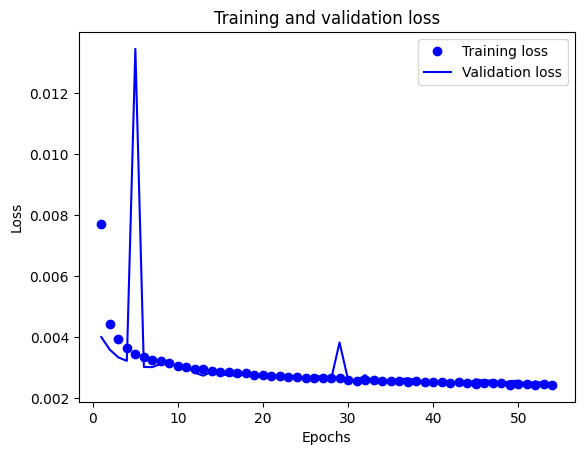

In [39]:
# Loss History
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Visualization
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Test

In [40]:
unet.load_weights('best_weights.keras')

num_iterations=10
mse_values = []

for _ in range(num_iterations):
    mse_metric = MeanSquaredError()

    for _ in range(10000 // batch_size):  # 10000 images divided per batch size
        masked_images, original_images = next(test_generator)
        inpainted_images = unet.predict(masked_images)

        mse_metric.update_state(original_images, inpainted_images)

        mse_value = mse_metric.result().numpy()
        mse_values.append(mse_value)

mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

print("Mean MSE over 10 iterations:", mean_mse)
print("Standard deviation of MSE over 10 iterations:", std_dev_mse)

Output streaming troncato alle ultime 5000 righe.
1/1 [==============================] - 0s 23ms/step
Mean MSE over 10 iterations: 0.0025416515
Standard deviation of MSE over 10 iterations: 7.6396944e-05


# Analysis of the configurations tested and the results obtained

1. First run:
  
  Simple UNet structure without batch normalization.

  Simple discriminator structure without batch normalization.

  Results:
    - Mean MSE over 10 iterations: 0.0024893119

2. Second run:

  More complex UNet structure with batch normalization.

  Simple discriminator structure without batch normalization.

  Results:
    - Mean MSE over 10 iterations: 0.0027026343
    - Standard deviation of MSE over 10 iterations: 6.727402e-05

3. Third run
  
  Training set size: 22000

  Test set size: 5000
  
  Split training set into:
    - Training set size: 17600 - 80%
    - Validation set size: 4400 - 20%

  More complex UNet structure with batch normalization.

  More complex discriminator structure with batch normalization.

  Results:
    - Mean MSE over 10 iterations: 0.0029612863
    - Standard deviation of MSE over 10 iterations: 8.1560036e-05

4. Fourth run
  Training set size: 20000

  Test set size: 7000

  Split training set into:
    - Training set size: 16000 - 80%
    - Validation set size: 4000 - 20%

  Simpler UNet structure without batch normalization.

  Simpler discriminator structure without batch normalization.

  Results:
  - Mean MSE over 10 iterations: 0.0024293815
  - Standard deviation of MSE over 10 iterations: 6.3358915e-05

----

### Fifth  run
- Training set size: 25000
- Test set size: 2000
- Split training set in:
    - Training set size: 20000 - 80%
    - Validation set size: 5000 - 20%

More complex UNet structure with batch normalization, dropout rate of 0.25, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

No discriminator, only UNet.

Adam Optimizer, learning rate=0.0002.

Loss function used for training: [MSE, binary cross-entropy]

Results:
- Mean MSE over 10 iterations: 0.0028412298
- Standard deviation of MSE over 10 iterations: 8.9701745e-05
----
### Sixth run
More complex UNet structure with batch normalization, dropout rate of 0.25, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

No discriminator, only UNet.

Adam Optimizer: learning rate=0.00005, beta_1=0.5.

Loss function used for training: [MSE, binary cross-entropy]

- Training set size: 25000
- Test set size: 2000
- Split training set in:
    - Training set size: 20000 - 80%
    - Validation set size: 5000 - 20%

Results:
- Mean MSE over 10 iterations: 0.002874413
- Standard deviation of MSE over 10 iterations: 0.00062927575
----
### Seventh Run
struttura unet più complessa, con batch normalization, tasso di dropout di 0.50, funzioni di attivazione relu per tutti i layer di encoding, funzioni di attivazione leaky relu per tutti i layer di decoding (eccetto il primo, ovvero l'ultimo inserito nel modello)

More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.00001, beta_1=0.5.

Loss function used for training: MSE

- Training set size: 17000
- Test set size: 10000
- Split training set in:
    - Training set size: 13600 - 80%
    - Validation set size: 3400 - 20%

Results:
- Mean MSE over 10 iterations: 0.0070565357
- Standard deviation of MSE over 10 iterations: 0.0010732944
----
### Eighth Run
More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.0001, beta_1=0.5.

Loss function used for training: binary cross-entropy

- Training set size: 17000
- Test set size: 10000
- Split training set in:
    - Training set size: 13600 - 80%
    - Validation set size: 3400 - 20%

Results:
- Mean MSE over 10 iterations: 0.0043243095
- Standard deviation of MSE over 10 iterations: 0.0017905211
----
### Ninth Run
More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.00005, beta_1=0.5.

Loss function used for training: SSIMLoss

Results:
- Mean MSE over 10 iterations: 0.007520574
- Standard deviation of MSE over 10 iterations: 0.0018593722
----
### Tenth Run
More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.00005, beta_1=0.5.

Loss function used for training: [MSE, SSIMLoss]

- Training set size: 17000
- Test set size: 10000
- Split training set in:
    - Training set size: 13600 - 80%
    - Validation set size: 3400 - 20%

Results:
- Mean MSE over 10 iterations: 0.004440206
- Standard deviation of MSE over 10 iterations: 0.0018343006
----
### Eleventh Run
More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.00005, beta_1=0.5.

Dropout rate = 0.50

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 17000
- Test set size: 10000
- Split training set in:
    - Training set size: 13600 - 80%
    - Validation set size: 3400 - 20%

Results:
- Mean MSE over 10 iterations: 0.0038432286
- Standard deviation of MSE over 10 iterations: 0.0010300091
----
### Twelfth Run
More complex UNet structure with batch normalization, dropout rate of 0.50, ReLU activation functions for all encoding layers, leaky ReLU activation functions for all decoding layers (except the first).

Adam Optimizer: learning rate=0.00005, beta_1=0.5.

Dropout rate = 0.50

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 26000
- Test set size: 1000
- Split training set in:
    - Training set size: 23400 - 90%
    - Validation set size: 2600 - 10%

Results:
- Mean MSE over 10 iterations: 0.004505807
- Standard deviation of MSE over 10 iterations: 0.0012829972
----
### Thirteenth Run
### Maybe overfitting of the model

Simpler UNet structure without batch normalization, without any dropout rate, ReLU activation functions for all layers.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 25000
- Test set size: 2000
- Split training set in:
    - Training set size: 20000 80%
    - Validation set size: 5000 20%

Results:
- Mean MSE over 10 iterations: 0.0021553743
- Standard deviation of MSE over 10 iterations: 0.000814344
----
### Fourteenth Run
### Maybe the best configuration
Simpler UNet structure without batch normalization, without any dropout rate, ReLU activation functions for encoding layers, ReLU activation functions for all decoding layers except the first.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 25000
- Test set size: 2000
- Split training set in:
    - Training set size: 20000 80%
    - Validation set size: 5000 20%

Results:
- Mean MSE over 10 iterations: 0.0023337966
- Standard deviation of MSE over 10 iterations: 0.0008417629
----
### Fifteenth Run
Simpler UNet structure with a bottleneck of 256 filters, without batch normalization, without any dropout rate, ReLU activation functions for encoding layers, ReLU activation functions for all decoding layers except the first.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 25000
- Test set size: 2000
- Split training set in:
    - Training set size: 20000 80%
    - Validation set size: 5000 20%

Results:
- Mean MSE over 10 iterations: 0.002829249
- Standard deviation of MSE over 10 iterations: 0.0008721559
----
### Sixteenth Run
Simpler UNet structure with a bottleneck of 512 filters, with batch normalization, without any dropout rate, ReLU activation functions for encoding layers, ReLU activation functions for all decoding layers except the first.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 22000
- Test set size: 5000
- Split training set in:
    - Training set size: 17600 80%
    - Validation set size: 5000 20%

Results:
- Mean MSE over 10 iterations: 0.0024674388
- Standard deviation of MSE over 10 iterations: 0.0009573754
----
### Seventeenth Run
Simpler UNet structure with a bottleneck of 512 filters, with batch normalization, without any dropout rate, ReLU activation functions for encoding layers, ReLU activation functions for all decoding layers except the first.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 22000
- Test set size: 5000
- Split training set in:
    - Training set size: 17600 80%
    - Validation set size: 4400 20%

Results:
- Mean MSE over 10 iterations: 0.002518289
- Standard deviation of MSE over 10 iterations: 7.7877914e-05
----
### Eighteenth Run
Simpler UNet structure with a bottleneck of 512 filters, with batch normalization, without any dropout rate, ReLU activation functions.

Adam Optimizer: learning rate=0.00005, beta_1=0.5

Loss function used for training: [MSE, SSIMLoss, binary cross-entropy]

- Training set size: 17000
- Test set size: 10000
- Split training set in:
    - Training set size: 13600
    - Validation set size: 3400

Results:
- Mean MSE over 10 iterations: 0.0025416515
- Standard deviation of MSE over 10 iterations: 7.6396944e-05

# Inpainted images visualization

1/1 [==============================] - 0s 24ms/step


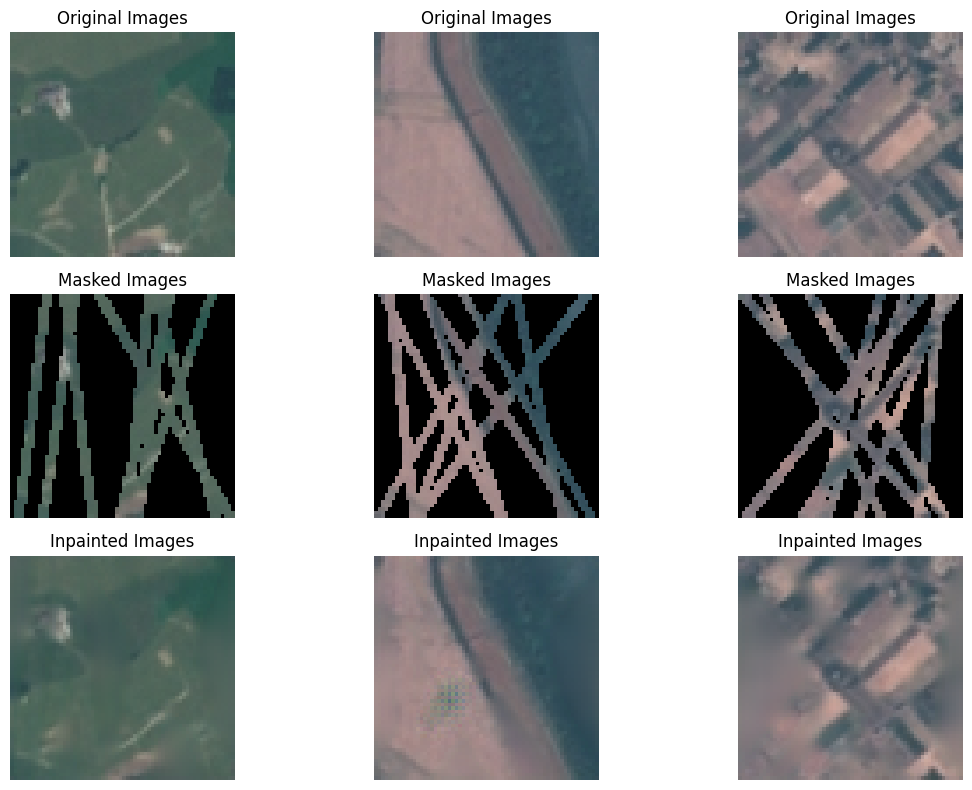

In [58]:
masked_images, original_images = next(test_generator)

inpainted_images = unet.predict(masked_images)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))

for i in range(3):

  # first row: plot original images
    axes[0, i].imshow(original_images[i])
    axes[0, i].set_title("Original Images")
    axes[0, i].axis('off')

    # second row: plot masked images
    axes[1, i].imshow(masked_images[i])
    axes[1, i].set_title("Masked Images")
    axes[1, i].axis('off')

    # third row: plot inpainted images
    axes[2, i].imshow(inpainted_images[i])
    axes[2, i].set_title("Inpainted Images")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()
